In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import math
import numpy as np
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from wordcloud import WordCloud
import os
os.chdir("C:\\Users\\Nacho MPra\\OneDrive\\Escritorio\\DATA TOOLS\\CONTENIDO THE BRIDGE\\EDA_Tiktok_Spotify") #almacenar viz en esta carpeta
import warnings
warnings.filterwarnings("ignore")

In [62]:
# Función para estructurar visualizaciones
def custom_sort(area):
    if "Europe" in area:
        return 1
    elif "America" in area:
        return 2
    elif "Asia" in area:
        return 3
    else:
        return 4
# Función para asignar tempo y dance_ind
def traduccion_bpm(bpm):
    if bpm < 40:
        return "Muy lento"
    elif 40 <= bpm <= 60:
        return "Largo"
    elif 60 < bpm <= 66:
        return "Larghetto"
    elif 66 < bpm <= 76:
        return "Adagio"
    elif 76 < bpm <= 108:
        return "Andante"
    elif 108 < bpm <= 120:
        return "Moderato"
    elif 120 < bpm <= 156:
        return "Allegro"
    elif 156 < bpm <= 176:
        return "Vivace"
    elif 176 < bpm <= 200:
        return "Presto"
    else:
        return "Prestissimo"
    #(0-20,20-40,40-60,60-80,80-100)
def ind_dance(danceability):
    if danceability < 20:
        return "0-20"
    elif 20 <= danceability <= 40:
        return "20-40"
    elif 40 < danceability <= 60:
        return "40-60"
    elif 60 < danceability <= 80:
        return "60-80"
    elif 80 < danceability <= 100:
        return "80-100"


def ind_pos(positiveness):
    if positiveness < 20:
        return "0-20"
    elif 20 <= positiveness <= 40:
        return "20-40"
    elif 40 < positiveness <= 60:
        return "40-60"
    elif 60 < positiveness <= 80:
        return "60-80"
    elif 80 < positiveness <= 100:
        return "80-100"

def group_rank(ranking):
    if 1 > ranking <= 5:
        return "1-5"
    elif 5 > ranking <= 10:
        return "6-10"
    elif 10 > ranking <= 15:
        return "10-15"
    elif 15 > ranking <= 20:
        return "16-20"
    elif 20 > ranking <= 25:
        return "20-25"
    elif 25 > ranking <= 30:
        return "26-30"
    elif 30 > ranking <= 35:
        return "30-35"
    elif 35 > ranking <= 40:
        return "36-40"
    elif 40 > ranking <= 45:
        return "40-45"
    elif 45 > ranking <= 50:
        return "46-50"    


#Parseo de ms a minutos:segundos    
def format_duration(ms):
    # Convertir milisegundos a segundos (como enteros)
    seconds = int(ms // 1000)
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:02d}:{seconds:02d}"

# Normalizar las características para radar plot
def normalize_features(features):
    min_max_values = {
        'loudness_db': (top50_songs_world['loudness_db'].min(), top50_songs_world['loudness_db'].max()),    # Escala típica de loudness en dB
        'energy': (0, 100),
        'danceability': (0, 100),
        'positiveness': (0, 100),
        'speechiness': (0, 100),
        'liveness': (0, 100),
        'acousticness': (0, 100),
        'instrumentalness': (0, 100),      
        'tempo_bpm': (0, 240),          # BPM típicos
        'Duration': (0, (top50_songs_world['Duration'].max())),       
        'Explicit': (0, 1),        
        'Popularity': (0, 100)     
    }
    return {key: (value - min_value) / (max_value - min_value)
            for key, value in features.items()
            for min_value, max_value in [min_max_values[key]]}




## Tema

En este NoteBook vamos a analizar la influencia, o no, de las tendencias sonoras de Tiktok en Spotify y veremos cuáles son las características que definen a una canción trendy en esta red social.

## Hipótesis

Partiendo de este tema, hay varias hipótesis que buscaremos comprobar:

1. **Popularidad en Spotify**  
   Las canciones que son tendencia en TikTok se corresponderán con un índice de popularidad alto en Spotify.

2. **Características musicales y ranking en TikTok**  
   Las canciones con tempos rápidos, un índice alto de *danceability*  y en tonalidad mayor tendrán un mejor posicionamiento dentro del ranking de TikTok.

3. **Similitud entre rankings globales y regionales**  
   El *Top 5 Global* se va a asemejar al *Top 5* de las áreas geográficas de Europa y América.

4. **Influencia de la estacionalidad**  
   Habiendo realizado la extracción el 27/12, y sabiendo de la inmediatez de las redes sociales, encontraremos canciones temáticas de Navidad en puestos intermedios del ranking.


## Creación del DataSet

Para la creación del DataSet, se ha procedido a extraer información de la página: [TikTok Creative Center - Popular Music](https://ads.tiktok.com/business/creativecenter/inspiration/popular/music/pc/en), parametrizando la búsqueda en los últimos **120 días** (a fecha de extracción **27/12/2024**), y para todos los países disponibles en el selector (**71 en total**).

Con este DataSet inicial, se ha ido enriqueciendo con metadatos musicales mediante los siguientes pasos:

1. **API de Spotify**:  
   - Se buscó cada una de las canciones del listado en la API de Spotify para obtener su **Track_ID**, **duración**, y otros datos relacionados. De aquí generamos el csv: top120_spoti_basicinfo.csv.
   
2. **Musicstax**:  
   - Una vez obtenido el **Track_ID**, se iteró sobre cada canción en la página [Musicstax](https://musicstax.com/) para obtener los metadatos musicales adicionales, como **loudness**, **beat**, **energy**, entre otros. De aquí generamos el csv: songs_details.csv.

El proceso de extracción está documentado dentro del repositorio.

In [34]:
songs_details = pd.read_csv('songs_details.csv', index_col=0) #spotify_id y track_features
songs_details = songs_details.drop_duplicates(subset='Track_ID', keep='first') #eliminamos duplicados
top100_songs_world_basic = pd.read_csv('top120_spoti_basicinfo.csv', index_col=0) #top 100 de los paises disponibles en la web de tiktok, duranta los 120 días anteriores al  27 de Diciembre
top100_songs_world_basic = top100_songs_world_basic.rename(columns={"id": "Country_ID"})
top100_songs_world = top100_songs_world_basic.merge(songs_details, on='Track_ID', how='left')
top100_songs_world.head()

,Artista,Cancion,Ranking,Pais,Country_ID,Track_ID,Explicit,Release_Date,Release_Date_Precision,Album_Type,...,key,loudness,beat,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
0,DobleP & Tuti Dj & PEREIRAREMIX,SE DICE DE MI,1,Argentina,AR,2wEhjcnre2PU36KQNBLXCC,True,2024-09-11,day,single,...,D Maj,-7.56db,4/4,52%,71%,82%,23%,50%,10%,0%
1,renzo ed & ELAGGUME,COLOCARTELO,2,Argentina,AR,4xXvGEiTkoaIkOMWa4u3Mn,False,2024-10-24,day,single,...,C min,-3.48db,4/4,70%,86%,81%,6%,4%,43%,0%
2,FloyyMenor,PELIGROSA,3,Argentina,AR,42wdz3j7gstgUuhoFLCXqd,True,2024-08-09,day,album,...,F# min,-7.43db,4/4,52%,76%,80%,6%,8%,22%,0%
3,Standly,Pégate,4,Argentina,AR,3E8xyYdIPpiH2wNEozE68I,False,2022-01-03,day,single,...,G Maj,-5.03db,4/4,82%,83%,83%,6%,9%,31%,0%
4,Valentino Merlo & The La Planta,Hoy,5,Argentina,AR,0SoBfYjQHvL6cuWHtPUYnq,False,2024-05-22,day,single,...,B Maj,-4.61db,4/4,71%,45%,66%,4%,15%,24%,0%


## Limpieza del DataSet
Por seguridad la pagina de TikTok no proporciona el listado completo de 100 canciones para el periodo que seleccionemos. Por otra parte, algunos de los sonidos que son tendencia no son canciones como tal, son efectos sonoros por ejemplo, y se escapan del objeto de estudio. Por lo que vamos a ver el mínimo de canciones válidas, tanto por no haber conseguido su track_id, como por no tener información detallada disponible, que tiene un país, para que marque nuestro límite (Top N) y nos permita un estudio homogéneo del fenómeno. Hemos seleccionado 'loudness' para filtrar ya que si no hay información de un track_feature no hay del resto.

Primero vamos a hacer un .describe() para apreciar si hay algún cambio estructural adicional necesario antes de reducir el dataset.

In [35]:
top100_songs_world.describe(include='all')

,Artista,Cancion,Ranking,Pais,Country_ID,Track_ID,Explicit,Release_Date,Release_Date_Precision,Album_Type,...,key,loudness,beat,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
count,6945,6945,6945.000000,6945,6945,6336,6336,6336,6336,6336,...,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482
unique,2300,2547,NaN,71,71,2336,2,1175,2,3,...,24,923,4,100,89,97,56,85,101,89
top,Altitude Music / BMGPM,Forever Young,NaN,Bangladesh,BD,5rwQGBi5mdmU7dqNM7x9Oo,False,2024-08-23,day,single,...,C# Maj,-2.49db,4/4,91%,74%,72%,4%,9%,0%,0%
freq,114,71,NaN,100,100,67,5152,115,6206,3953,...,457,68,4924,198,221,193,1208,545,368,3537
mean,NaN,NaN,50.414399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,28.868952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Viendo que no hay correspondencia Cancion - Track_ID 1 a 1, analizamos el por qué:

In [36]:
top100_songs_world[['Cancion', 'Track_ID']].describe(include='all')

,Cancion,Track_ID
count,6945,6336
unique,2547,2336
top,Forever Young,5rwQGBi5mdmU7dqNM7x9Oo
freq,71,67


#### Observaciones
Viendo las canciones y atendiendo los casos individuales, se identificaron las siguientes situaciones:
1. **Nombres escritos de forma diferente pero corresponden a la misma canción:**
    - Artista = Karina y Marina & Hugo23 & Sennior
    - Cancion = Bombon Karina VS Sennior
    - Cancion = Bombon Karina VS Hugo23    
2. **Fragmentos de canciones vs. canciones completas:**
    - Artista = kuqe 2115 & francis
    - Cancion = taki mały ja	
    - Cancion = taki mały ja (Preview)	
3. **Remixes o versiones aceleradas que no están disponibles en Spotify:**
    - Artista = Mega Shinnosuke
    - Cancion = Ai To U	
    - Cancion = Ai To U (Sped Up Ver.)
#### Decisión
Optamos por unificar las entradas hacia la canción disponible en Spotify. Aunque estas versiones no tengan las mismas `track_features`, compartirán las características suficientes para continuar con el estudio y evitar que aparezcan duplicadas en el ranking.

El procedimiento va a ser, mantener la canción con mejor posicionamiento en ranking y dejar la información de la canción original, ya que es de la que obtenemos todo el detalle de Spotify

In [37]:
# Crear una nueva columna con la longitud de la canción
top100_songs_world['Cancion_Length'] = top100_songs_world['Cancion'].str.len()

# Ordenar el DataFrame por 'Ranking' (ascendente) y luego por 'Cancion_Length' (ascendente)
top100_songs_world = top100_songs_world.sort_values(by=['Ranking', 'Cancion_Length'])

# Eliminar duplicados de Track_ID, quedándote con la primera ocurrencia después de ordenar
top100_songs = top100_songs_world.drop_duplicates(subset='Track_ID', keep='first')
top100_songs = top100_songs[top100_songs['loudness'].notnull()]
# Mostrar el resultado
top100_songs[['Cancion', 'Track_ID']].describe(include='all')


,Cancion,Track_ID
count,2034,2034
unique,1989,2034
top,Funny,2PpruBYCo4H7WOBJ7Q2EwM
freq,5,1


Ya el "descuadre" entre canción y Track_ID viene porque dependiendo del mercado (país) en el que está presente la canción, puede variar su Track_ID:

- **Canción**: Anaconda
- **Track_ID**: 5eqiMMbaeUZ32Q7sS00H35
- **Mercados**: ["AR", "AU", "AT", "BE", "BO", "BR", "BG", "CL", "CO", "CR", "CY", "CZ", "DK", "DO", "DE", "EC", "EE", "SV", "FI", "FR", "GR", "GT", "HN", "HK", "HU", "IS", "IE", "IT", "LV", "LT", "LU", "MY", "MT", "NL", "NZ", "NI", "NO", "PA", "PY", "PE", "PH", "PL", "PT", "SG"]
- **Track_ID 2**: 794F99D5BQHS5ZGRXAs7I5
- **Mercados**: ["CA","MX","US"]



### Definición Top N

In [38]:
valid_count = pd.DataFrame(top100_songs_world[top100_songs_world['loudness'].notnull()].groupby('Pais')['loudness'].count()).rename(columns={"loudness": "valid_songs"})
(round(len(valid_count[valid_count['valid_songs']>50])/len(valid_count)*100))

94

In [39]:
# Filtrar canciones con valores no nulos en 'loudness'
top100_songs_world_clean = top100_songs_world[top100_songs_world['loudness'].notnull()]
top100_songs_world_clean = top100_songs_world_clean.sort_values(by=['Pais', 'Ranking'])
top100_songs_world_clean['New_Ranking'] = top100_songs_world_clean.groupby('Pais').cumcount() + 1

valid_countries = top100_songs_world_clean['Pais'].value_counts()
valid_countries = valid_countries[valid_countries >= 50].index

# Filtrar el dataset inicial para que solo incluya estos países
top100_songs_world_clean = top100_songs_world_clean[top100_songs_world_clean['Pais'].isin(valid_countries)]
# Asignar nuevo ranking por país
top100_songs_world_clean['New_Ranking'] = top100_songs_world_clean.groupby('Pais').cumcount() + 1

# Filtrar solo las primeras 50 canciones por país
top50_songs_world = top100_songs_world_clean[top100_songs_world_clean['New_Ranking'] <= 50]

top50_songs_world = top50_songs_world.drop(columns='Ranking').rename(columns={"New_Ranking": "Ranking"})
top50_songs_world = top50_songs_world.drop(columns='Unnamed: 0', errors='ignore')  # Ignorar error si no existe
top50_songs_world


,Artista,Cancion,Pais,Country_ID,Track_ID,Explicit,Release_Date,Release_Date_Precision,Album_Type,Popularity,...,beat,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness,Cancion_Length,Ranking
0,DobleP & Tuti Dj & PEREIRAREMIX,SE DICE DE MI,Argentina,AR,2wEhjcnre2PU36KQNBLXCC,True,2024-09-11,day,single,65.0,...,4/4,52%,71%,82%,23%,50%,10%,0%,13,1
1,renzo ed & ELAGGUME,COLOCARTELO,Argentina,AR,4xXvGEiTkoaIkOMWa4u3Mn,False,2024-10-24,day,single,74.0,...,4/4,70%,86%,81%,6%,4%,43%,0%,11,2
2,FloyyMenor,PELIGROSA,Argentina,AR,42wdz3j7gstgUuhoFLCXqd,True,2024-08-09,day,album,81.0,...,4/4,52%,76%,80%,6%,8%,22%,0%,9,3
3,Standly,Pégate,Argentina,AR,3E8xyYdIPpiH2wNEozE68I,False,2022-01-03,day,single,80.0,...,4/4,82%,83%,83%,6%,9%,31%,0%,6,4
4,Valentino Merlo & The La Planta,Hoy,Argentina,AR,0SoBfYjQHvL6cuWHtPUYnq,False,2024-05-22,day,single,77.0,...,4/4,71%,45%,66%,4%,15%,24%,0%,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6923,GREY D,dự báo thời tiết hôm nay mưa,Vietnam,VN,65cM1nyMf9pFDZVV8xmPX9,False,2022-11-22,day,single,59.0,...,4/4,56%,58%,26%,4%,9%,63%,0%,28,46
6924,队长,NUNA,Vietnam,VN,6L5ImrjJJKVYJQzjpARPXj,False,2022-08-31,day,single,53.0,...,4/4,68%,43%,42%,4%,10%,5%,0%,4,47
6926,NS Records,Take Your Ease Under The Stars,Vietnam,VN,7L785rjXacCL0K8DYueIGN,False,2022-12-15,day,single,15.0,...,4/4,17%,47%,6%,10%,24%,97%,22%,30,48
6928,Wxrdie,Nu Cep,Vietnam,VN,6ecdnYq7ob5tvxlT3U2xwV,True,2024-11-12,day,album,56.0,...,4/4,81%,88%,61%,14%,9%,8%,0%,6,49


#### Observaciones
Viendo que ajustando el Top N a 50 seguimos disponiendo del 94% de los países extraídos.

#### Decisiones
Optampos por ajustar el dataset para asegurar que todos los países que permanecen en el estudio puedan estar igualmente representados. Primero vamos a eliminar los valores nulos que no nos aportan información detallada, o que en la fase de extracción no hemos podido asociarlos a una canción.

Para poder trabajar más cómodos los datos de track_features pasamos a quitar los símbolos de porcentaje, la unidad de db, y separamos la tonalidad del modo (mayor y menor).

In [40]:
for feature in ['energy','danceability','positiveness','speechiness','liveness','acousticness','instrumentalness']:
    top50_songs_world[feature] = top50_songs_world[feature].str.replace('%', '').astype(float)
top50_songs_world['loudness'] = top50_songs_world['loudness'].str.replace('db', '').astype(float)
top50_songs_world['tempo_bpm'] = top50_songs_world['tempo'].str.replace(' BPM', '').astype(float)
top50_songs_world['tempo'] = top50_songs_world['tempo_bpm'].apply(traduccion_bpm)
top50_songs_world['dance_group'] = top50_songs_world['danceability'].apply(ind_dance)
top50_songs_world = top50_songs_world.rename(columns={"loudness": "loudness_db"})
#Creación columna key y mode (tonalidad y modo)
split_keys = top50_songs_world['key'].str.split(expand=True)
top50_songs_world['key'] = split_keys[0]
top50_songs_world['mode'] = split_keys[1]
top50_songs_world.head()

,Artista,Cancion,Pais,Country_ID,Track_ID,Explicit,Release_Date,Release_Date_Precision,Album_Type,Popularity,...,positiveness,speechiness,liveness,acousticness,instrumentalness,Cancion_Length,Ranking,tempo_bpm,dance_group,mode
0,DobleP & Tuti Dj & PEREIRAREMIX,SE DICE DE MI,Argentina,AR,2wEhjcnre2PU36KQNBLXCC,True,2024-09-11,day,single,65.0,...,82.0,23.0,50.0,10.0,0.0,13,1,180.0,60-80,Maj
1,renzo ed & ELAGGUME,COLOCARTELO,Argentina,AR,4xXvGEiTkoaIkOMWa4u3Mn,False,2024-10-24,day,single,74.0,...,81.0,6.0,4.0,43.0,0.0,11,2,96.0,80-100,min
2,FloyyMenor,PELIGROSA,Argentina,AR,42wdz3j7gstgUuhoFLCXqd,True,2024-08-09,day,album,81.0,...,80.0,6.0,8.0,22.0,0.0,9,3,100.0,60-80,min
3,Standly,Pégate,Argentina,AR,3E8xyYdIPpiH2wNEozE68I,False,2022-01-03,day,single,80.0,...,83.0,6.0,9.0,31.0,0.0,6,4,98.0,80-100,Maj
4,Valentino Merlo & The La Planta,Hoy,Argentina,AR,0SoBfYjQHvL6cuWHtPUYnq,False,2024-05-22,day,single,77.0,...,66.0,4.0,15.0,24.0,0.0,3,5,176.0,40-60,Maj


In [41]:
top50_songs_world[['Cancion','Track_ID']].describe(include='all')

,Cancion,Track_ID
count,3400,3400
unique,1256,1281
top,Forever Young,5G2f63n7IPVPPjfNIGih7Q
freq,66,58


## Enriquecemos el DataSet

Atendiendo al periodo que estamos analizando (29/08/2024 al 27/12/2024), nos encontramos ante dos periodos muy significativos que pueden aplicar una variante de estacionalidad al fenómeno. Esto ayudaría a entender las diferencias entre TikTok y Spotify a la hora de gestionar tendencias. 

Para enriquecer el análisis, vamos a cruzar con las playlists oficiales de Spotify para estas fiestas. Además, añadimos áreas geográficas para poder estudiar el fenómeno a un nivel más agregado en función de la localización.


In [42]:
season_songs = pd.read_csv('season_songs.csv', index_col=0)
season_songs = season_songs.rename(columns={'id':'Track_ID'})
geo_areas = pd.read_csv('geo_area.csv')
geo_areas = geo_areas.rename(columns={'ISO_Code':'Country_ID'}).drop(columns='Country')
top50_songs_world = top50_songs_world.merge(season_songs, on='Track_ID', how='left')
top50_songs_world['season'] = top50_songs_world['season'].fillna('no_season')
top50_songs_world = top50_songs_world.merge(geo_areas, on='Country_ID', how='left')
top50_songs_world = top50_songs_world.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
top50_songs_world

,Artista,Cancion,Pais,Country_ID,Track_ID,Explicit,Release_Date,Release_Date_Precision,Album_Type,Popularity,...,liveness,acousticness,instrumentalness,Cancion_Length,Ranking,tempo_bpm,dance_group,mode,season,Geographic_Area
0,DobleP & Tuti Dj & PEREIRAREMIX,SE DICE DE MI,Argentina,AR,2wEhjcnre2PU36KQNBLXCC,True,2024-09-11,day,single,65.0,...,50.0,10.0,0.0,13,1,180.0,60-80,Maj,no_season,South America
1,renzo ed & ELAGGUME,COLOCARTELO,Argentina,AR,4xXvGEiTkoaIkOMWa4u3Mn,False,2024-10-24,day,single,74.0,...,4.0,43.0,0.0,11,2,96.0,80-100,min,no_season,South America
2,FloyyMenor,PELIGROSA,Argentina,AR,42wdz3j7gstgUuhoFLCXqd,True,2024-08-09,day,album,81.0,...,8.0,22.0,0.0,9,3,100.0,60-80,min,no_season,South America
3,Standly,Pégate,Argentina,AR,3E8xyYdIPpiH2wNEozE68I,False,2022-01-03,day,single,80.0,...,9.0,31.0,0.0,6,4,98.0,80-100,Maj,no_season,South America
4,Valentino Merlo & The La Planta,Hoy,Argentina,AR,0SoBfYjQHvL6cuWHtPUYnq,False,2024-05-22,day,single,77.0,...,15.0,24.0,0.0,3,5,176.0,40-60,Maj,no_season,South America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,GREY D,dự báo thời tiết hôm nay mưa,Vietnam,VN,65cM1nyMf9pFDZVV8xmPX9,False,2022-11-22,day,single,59.0,...,9.0,63.0,0.0,28,46,77.0,40-60,Maj,no_season,Asia
3396,队长,NUNA,Vietnam,VN,6L5ImrjJJKVYJQzjpARPXj,False,2022-08-31,day,single,53.0,...,10.0,5.0,0.0,4,47,138.0,40-60,Maj,no_season,Asia
3397,NS Records,Take Your Ease Under The Stars,Vietnam,VN,7L785rjXacCL0K8DYueIGN,False,2022-12-15,day,single,15.0,...,24.0,97.0,22.0,30,48,144.0,40-60,Maj,no_season,Asia
3398,Wxrdie,Nu Cep,Vietnam,VN,6ecdnYq7ob5tvxlT3U2xwV,True,2024-11-12,day,album,56.0,...,9.0,8.0,0.0,6,49,105.0,80-100,min,no_season,Asia


## Analisis

### Matriz de Correlación

Para que nos sirva de guía de cara a validar nuestras hipótesis, primero vamos a pintar la Matriz de Correlación.

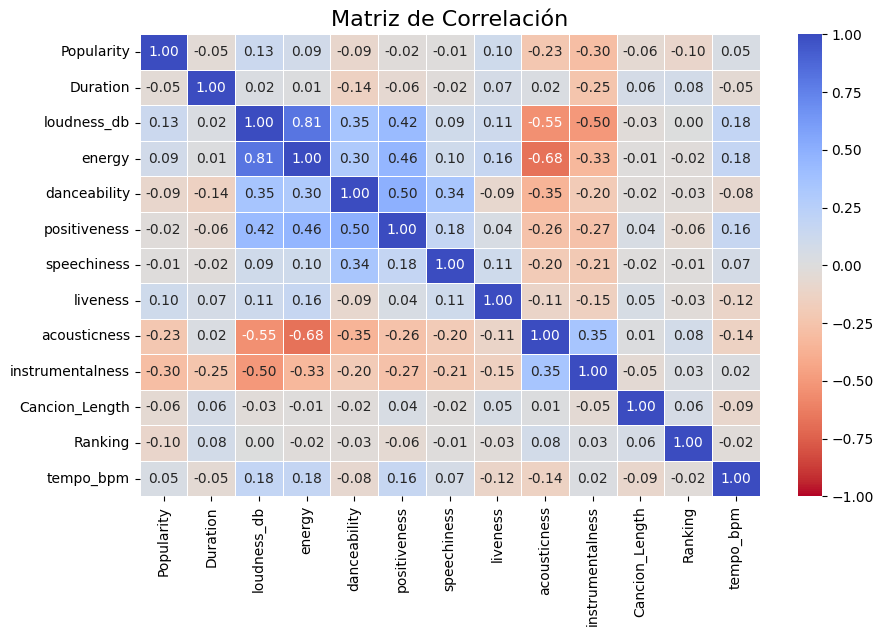

In [43]:
correlation_matrix = top50_songs_world.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm_r', fmt='.2f', linewidths=0.5, cbar=True, vmin=-1, vmax=1)

plt.title('Matriz de Correlación', fontsize=16)

plt.show()

### Hipotesis 1
**Popularidad en Spotify**  
   Las canciones que son tendencia en TikTok se corresponderán con un índice de popularidad alto en Spotify. Teniendo en cuenta que el índice hace referencia a la popularidad de esa canción dentro del catálogo del artista.

Ya la matriz de correlación nos avisa de que prácticamente no existe una dependencia entre estas variables **-0.09**.

Para comprobarlo, vamos a pintar un scatter plot en el que vamos a ver la mediana para cada posición del Ranking:

Con esta visuación podemos ver como a nivel global, todas las posiciones del ranking van a tener índices de popularidad entre 40 y 70%, siendo curioso como para las posiciones 1 y 6 del ranking tenemos populariades más bajas que la mediana global. De hecho, si miramos el primer cuartil, vemos como el 75% de los casos el índice de popularidad está por encima del 44%.

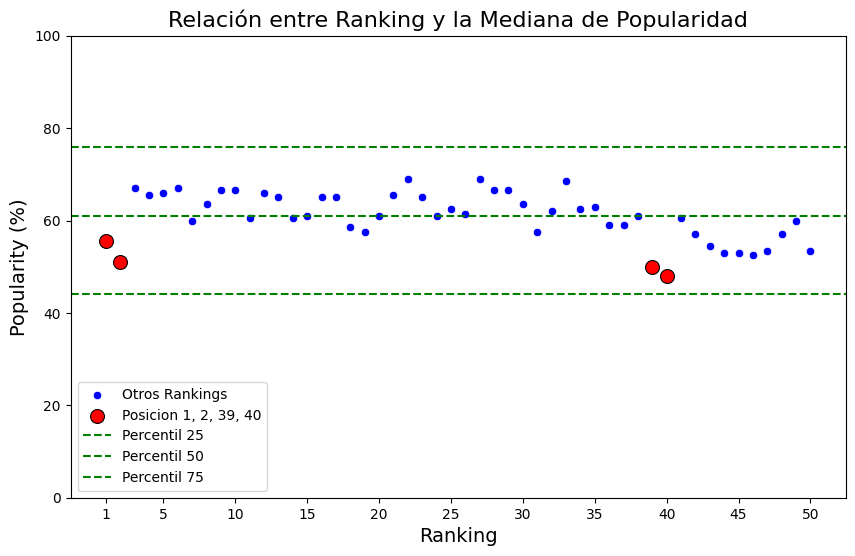

In [44]:
# Calcular percentiles 25, 50 y 75 para Popularity
percentiles = np.percentile(top50_songs_world['Popularity'], [25, 50, 75])

# Filtrar puntos con Ranking 1, 2, 39, 40
special_points = top50_songs_world[top50_songs_world['Ranking'].isin([1, 2, 39, 40])]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar todos los puntos
sns.scatterplot(x='Ranking', y=top50_songs_world.groupby('Ranking')['Popularity'].median(), data=top50_songs_world, color='blue', label='Otros Rankings')

# Graficar los puntos especiales (Ranking 1, 2, 39, 40)
sns.scatterplot(x='Ranking', y=top50_songs_world.groupby('Ranking')['Popularity'].median(), data=special_points, color='red', label='Posicion 1, 2, 39, 40', s=100, edgecolor='black')

# Añadir las líneas de referencia de percentiles
for idx, p in enumerate(percentiles):
    plt.axhline(y=p, color='green', linestyle='--', label=f'Percentil {25*(idx+1)}')

# Título y etiquetas
plt.title('Relación entre Ranking y la Mediana de Popularidad', fontsize=16)
plt.xlabel('Ranking', fontsize=14)
plt.ylabel('Popularity (%)', fontsize=14)

# Limitar el eje Y
plt.ylim(0, 100)

# Configuración de los ticks en el eje X
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
 

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [45]:
pd.DataFrame(top50_songs_world.groupby('Ranking')['Popularity'].median()[top50_songs_world.groupby('Ranking')['Popularity'].median() < top50_songs_world['Popularity'].median()])

,Popularity
Ranking,
1,51.0
6,60.0
10,60.5
13,60.5
17,58.5
18,57.5
30,57.5
35,59.0
36,59.0


Incluso si vemos qué ranking tienen las popularidades en el percentil 5, vemos que éstos siguen relativamente altos, teniendo de media una posición en la mitad del Top 50 (Posición 26)

In [46]:
pd.DataFrame(top50_songs_world[top50_songs_world['Popularity']<top50_songs_world['Popularity'].quantile(.05)].groupby('Popularity')['Ranking'].median())

,Ranking
Popularity,
2.0,19.0
3.0,16.5
6.0,31.0
9.0,25.5
10.0,26.0
12.0,32.0
13.0,27.5
14.0,48.0
15.0,26.5


In [47]:
print(f'La posición media de las popularides en el percentil 5 es la {int(round((top50_songs_world[top50_songs_world['Popularity']<top50_songs_world['Popularity'].quantile(.05)].groupby('Popularity')['Ranking'].median()).mean(),0))}º')

La posición media de las popularides en el percentil 5 es la 27º


In [48]:
#guardar para scar un spider graph con qué características tiene que tener una canción de popularidad baja para puntuar alto

less_popular = top50_songs_world[top50_songs_world['Popularity']<20]

def best_ranking_worst_popularity_by_area(group):
    # Obtener la canción con el mejor ranking (ranking más bajo)
    return group.loc[group['Ranking'].idxmin()]

result_by_area = less_popular.groupby('Geographic_Area').apply(best_ranking_worst_popularity_by_area)

top_rank_less_popular = pd.DataFrame(result_by_area).sort_values(by='Ranking', ascending=True)

### Hipotesis 2
   **Características musicales y ranking en TikTok**  
   Las canciones con tempos rápidos, un índice alto de *danceability* y en tono mayor tendrán un mejor posicionamiento dentro del ranking de TikTok.

   Volvemos a atender de nuevo a la matriz de correlaciones para orientarnos en este planteamiento. Y lo que vemos es que no tenemos una relación que determine que un índice alto de *danceability* o tempo rápido proporcione un acceso a los puestos más altos del Ranking (tenemos correlaciones de -0.02 y de -0.03 respectivamente).

   Y cómo podemos apreciar, en cuanto al Tempo no hay nignuna relación, y vemos bastante heterogeneidad dentro de las medianas para cada posición del Ranking. Mientras que en el índice *danceability* vemos lo contrario, mucha homogeneidad en torno a valores entre  el 60 y 80 por ciento, pero ningun tendencia en función a la posición del Ranking.

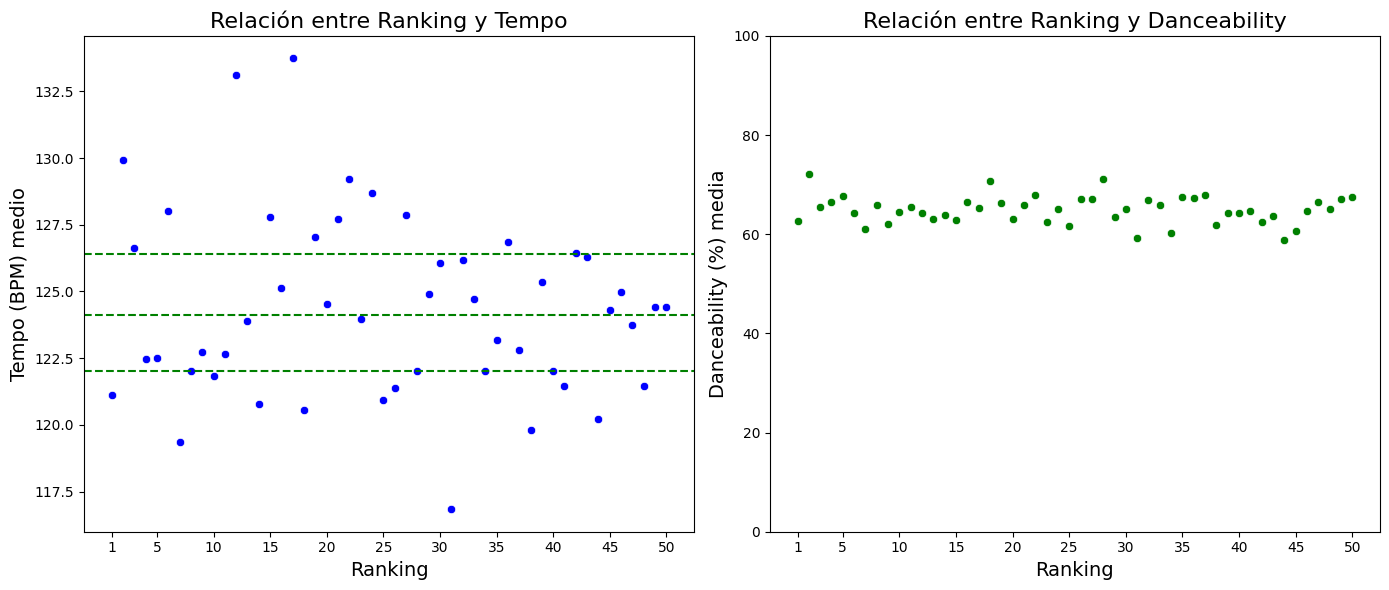

In [49]:

plt.figure(figsize=(14, 6))  

#Ranking vs Tempo
# Calcular percentiles 25, 50 y 75 para Popularity
percentiles = np.percentile(top50_songs_world.groupby('Ranking')['tempo_bpm'].mean(), [25, 50, 75])

plt.subplot(1, 2, 1)
sns.scatterplot(data=top50_songs_world, x='Ranking', y=top50_songs_world.groupby('Ranking')['tempo_bpm'].mean(), color='blue')
plt.title('Relación entre Ranking y Tempo', fontsize=16)
plt.xlabel('Ranking', fontsize=14)
plt.ylabel('Tempo (BPM) medio', fontsize=14)
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
# Añadir las líneas de referencia de percentiles
for idx, p in enumerate(percentiles):
    plt.axhline(y=p, color='green', linestyle='--', label=f'Percentil {25*(idx+1)}')

#Ranking vs Danceability
plt.subplot(1, 2, 2)
sns.scatterplot(data=top50_songs_world, x='Ranking', y=top50_songs_world.groupby('Ranking')['danceability'].mean(), color='green')
plt.title('Relación entre Ranking y Danceability', fontsize=16)
plt.xlabel('Ranking', fontsize=14)
plt.ylabel('Danceability (%) media', fontsize=14)
plt.ylim(0, 100)
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

plt.tight_layout()

plt.show()



 Aunque es cierto que hay una concetración en torno a índice de danceability que indica que la tendencia es que las canciones sean bailables, y el tempo se encuentra entre los valores del rango más común en Spotify (90 y 99 BPM) y el más reproducido (140-149 BPM), como podemos observar en este [estudio](https://blog.musiio.com/posts/which-musical-tempos-are-people-streaming-the-most).

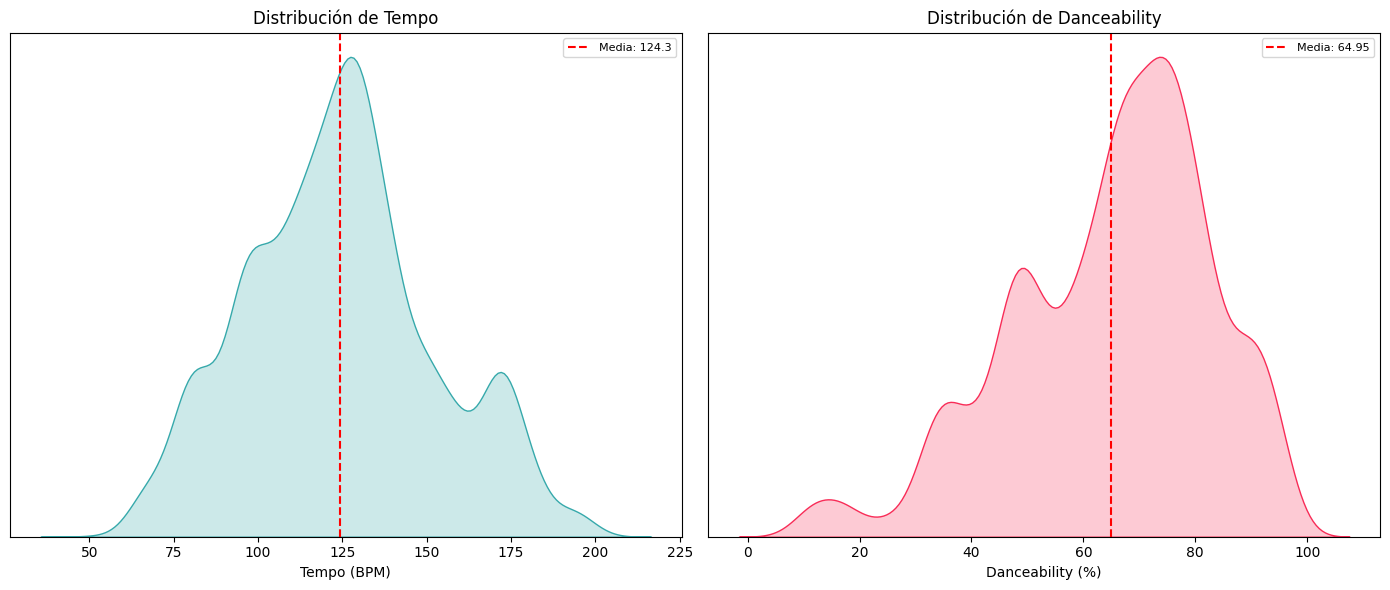

In [50]:
plt.figure(figsize=(14, 6))

# Gráfico para 'tempo'
plt.subplot(1, 2, 1)
sns.kdeplot(data=top50_songs_world['tempo_bpm'], shade=True, color='#36a9ab').axes.get_yaxis().set_visible(False)
plt.axvline(top50_songs_world['tempo_bpm'].mean(), color='red', linestyle='--', label=f'Media: {top50_songs_world['tempo_bpm'].mean():.1f}')
plt.xlabel('Tempo (BPM)')
plt.ylabel('')
plt.title('Distribución de Tempo')
plt.legend(fontsize=8)

# Gráfico para 'danceability'
plt.subplot(1, 2, 2)
sns.kdeplot(data=top50_songs_world['danceability'], shade=True, color='#f82c57').axes.get_yaxis().set_visible(False)
plt.axvline(top50_songs_world['danceability'].mean(), color='red', linestyle='--', label=f'Media: {top50_songs_world['danceability'].mean():.2f}')
plt.xlabel('Danceability (%)')
plt.ylabel('')
plt.title('Distribución de Danceability')
plt.legend(fontsize=8)

plt.tight_layout()

plt.show()


De hecho, aunque lo veamos por países más distribuido, la centralidad gira en torno a los extremos de los rango que veíamos antes, 90 y 149 BPM

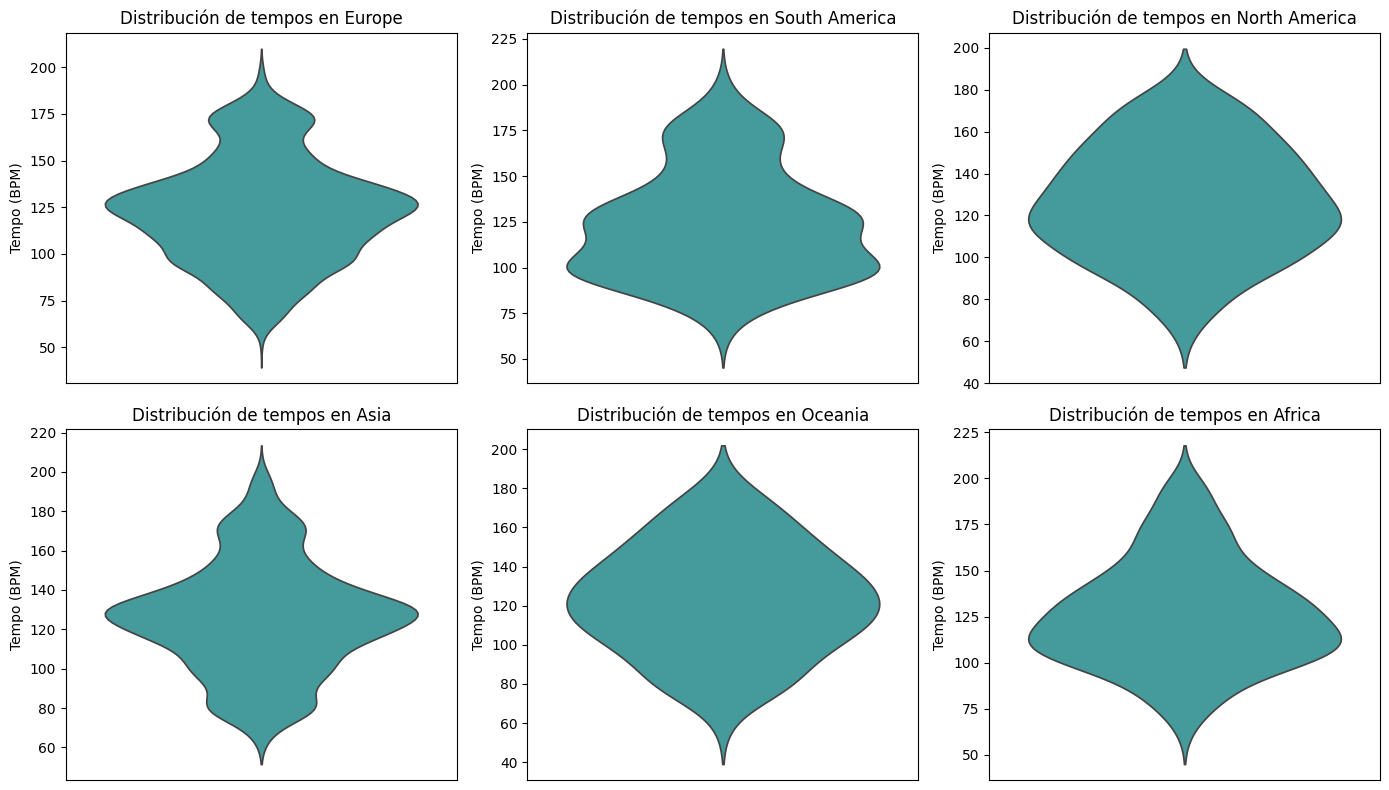

In [59]:

# Crear una lista de áreas geográficas únicas y ordenarlas
areas = sorted(top50_songs_world['Geographic_Area'].unique(), key=custom_sort)

# Definir el número de filas y columnas para la cuadrícula
n_cols = 3  # Número de gráficos por fila
n_rows = math.ceil(len(areas) / n_cols)  # Calcular el número de filas necesario

# Configurar el tamaño del canvas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))  # Tamaño ajustado
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

# Iterar por cada área y crear un gráfico
for i, area in enumerate(areas):
    ax = axes[i]
    
    # Filtrar datos por área
    area_data = top50_songs_world[top50_songs_world['Geographic_Area'] == area]
    
    # Calcular la mediana global del tempo
    tempo_median = area_data['tempo_bpm'].median()
   
    # Añadir el violinplot
    sns.violinplot(x="Geographic_Area", y="tempo_bpm", data=area_data, inner=None, ax=ax, color='#36a9ab')

    # Configurar etiquetas y título para cada subgráfico
    #ax.set_xlabel('Distribución', fontsize=10)
    ax.set_ylabel('Tempo (BPM)', fontsize=10)
    ax.set_title(f'Distribución de tempos en {area}', fontsize=12)
    ax.get_yaxis().set_visible(True)  # Mostrar el eje Y
    ax.set_xticks([])  # Quita los ticks del eje X
    ax.set_xlabel('')  # Borra el texto de la etiqueta X

# Desactivar gráficos vacíos si el número de áreas no llena la cuadrícula
for ax in axes[len(areas):]:
    ax.axis('off')

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar el gráfico
plt.show()



Hablar de los modos mayores

In [66]:
top50_songs_world['rank_group'] = top50_songs_world['Ranking'].apply(group_rank)
top50_songs_world['pos_group'] = top50_songs_world['positiveness'].apply(ind_pos)

ranking_tone = (top50_songs_world.groupby(['Geographic_Area','mode'])['Cancion'].count().reset_index()).rename(columns={'Geographic_Area':'source',
                                                                                                               'mode':'target',
                                                                                                               'Cancion':'value'})
ranking_tone_mode = (top50_songs_world.groupby(['mode','pos_group'])['Cancion'].count().reset_index()).rename(columns={'mode':'source',
                                                                                                               'pos_group':'target',
                                                                                                               'Cancion':'value'})
sankey_tone = pd.concat([ranking_tone,ranking_tone_mode], axis=0).sort_values(by=['source','target'])

unique_labels = list(set(sankey_tone['source']).union(set(sankey_tone['target'])))
label_to_index = {label: i for i, label in enumerate(unique_labels)}

In [67]:
# Primero agrupamos las medidas que vamos a utilizar para ayudar en la visualización del Sankey Plot
top50_songs_world['rank_group'] = top50_songs_world['Ranking'].apply(group_rank)
top50_songs_world['pos_group'] = top50_songs_world['positiveness'].apply(ind_pos)

# Genramos la tabla que va a leer, atendiendo al flujo de cada nodo
ranking_tone = (top50_songs_world.groupby(['Geographic_Area','mode'])['Cancion'].count().reset_index()).rename(columns={'Geographic_Area':'source',
                                                                                                               'mode':'target',
                                                                                                               'Cancion':'value'})
ranking_tone_mode = (top50_songs_world.groupby(['mode','pos_group'])['Cancion'].count().reset_index()).rename(columns={'mode':'source',
                                                                                                               'pos_group':'target',
                                                                                                               'Cancion':'value'})
sankey_tone = pd.concat([ranking_tone,ranking_tone_mode], axis=0).sort_values(by=['source','target'])

# Generamos labels para mapear en el diagrama
unique_labels = list(set(sankey_tone['source']).union(set(sankey_tone['target'])))
label_to_index = {label: i for i, label in enumerate(unique_labels)}

sankey_tone['source'] = sankey_tone['source'].map(label_to_index)
sankey_tone['target'] = sankey_tone['target'].map(label_to_index)

# Generamos el Sankey
link = dict(source = sankey_tone['source'], target = sankey_tone['target'], value = sankey_tone['value'])
data = go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=unique_labels  
    ),
    link=link
)

#Ajuste visual
fig = go.Figure(data)
fig.update_layout(
    width=1400,  
    height=700, 
    title='Distribución por tonalidad (Maj vs. Min) e índice de Positividad Agrupado'
)
fig.show()

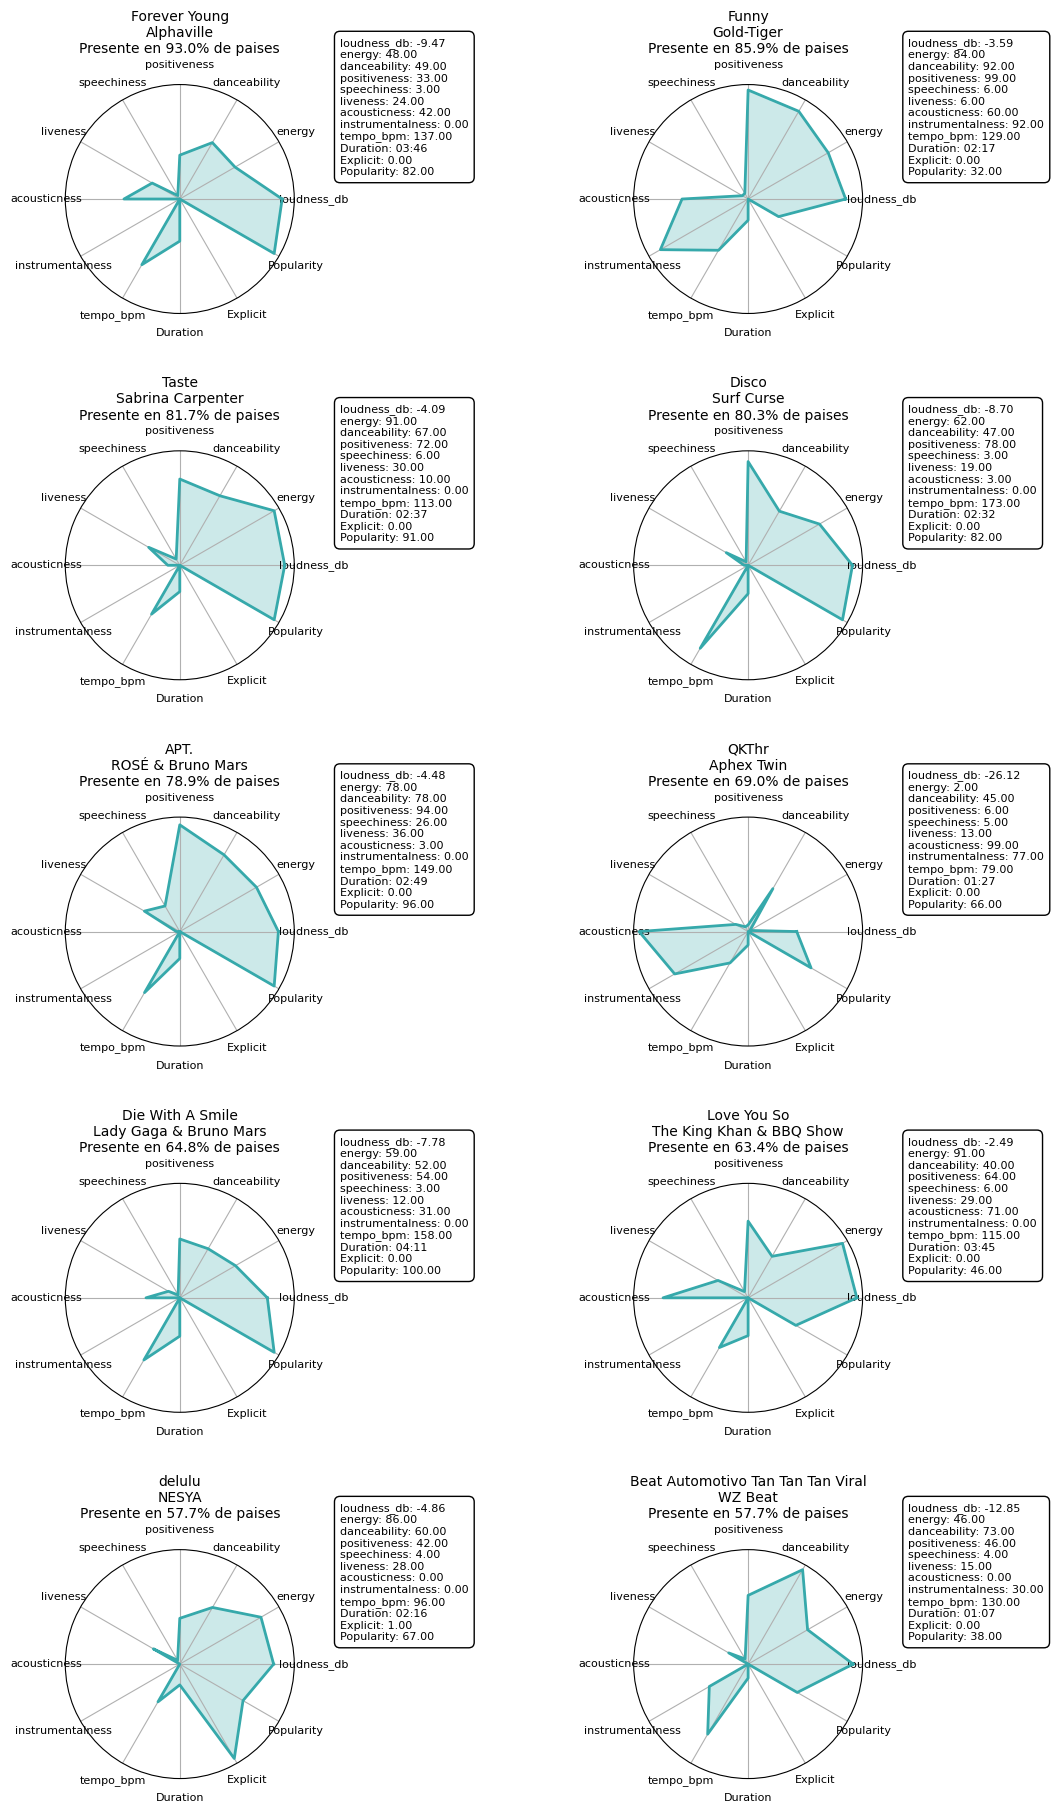

In [55]:
# Sacamos una lista de las 10 más presentes en los rankings de todos los países
song_count = top50_songs_world['Cancion'].value_counts().sort_values(ascending=False).head(10)
song_list = list(song_count.index)
presence = (top50_songs_world['Cancion'].value_counts().sort_values(ascending=False).head(10)).values

# Crear los subplots en formación de 2 filas y 5 columnas para visualizar
fig, axes = plt.subplots(5, 2, figsize=(14, 22), subplot_kw=dict(polar=True))  # Reducimos el ancho para evitar exceso de espacio horizontal
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

for i, song in enumerate(song_list):
    # Obtener detalles de la canción para visualizar
    song_details = top50_songs_world[top50_songs_world['Cancion'] == song].iloc[0]
    
    # Extraer las medidas
    features = {
        'loudness_db': song_details['loudness_db'],
        'energy': song_details['energy'],
        'danceability': song_details['danceability'],
        'positiveness': song_details['positiveness'],
        'speechiness': song_details['speechiness'],
        'liveness': song_details['liveness'],
        'acousticness': song_details['acousticness'],
        'instrumentalness': song_details['instrumentalness'],
        'tempo_bpm': song_details['tempo_bpm'],
        'Duration': song_details['Duration'],
        'Explicit': song_details['Explicit'],
        'Popularity': song_details['Popularity']
    }
    
    # Normalizamos para poder representar en una misma escala
    normalized_features = normalize_features(features)
    
    categories = list(normalized_features.keys())
    values = list(normalized_features.values())
    values += values[:1]  # Repetir el primer valor para cerrar el gráfico
    
    # Generamos el ángulo de cada categoría
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    # Creamos el radar plot en el subplot correspondiente
    ax = axes[i]
    ax.fill(angles, values, color='#36a9ab', alpha=0.25)
    ax.plot(angles, values, color='#36a9ab', linewidth=2)
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)

    # Aquí generamos el texto de la leyenda usando las medidas originales, sin normalizar
    legend_text = '\n'.join([f'{category}: {value:.2f}' if category != 'Duration' else f'{category}: {format_duration(features[category])}'
                            for category, value in features.items()])

    # Ajustamos posición del cuadro de leyendas para evitar que entorpezca la visión del plot
    ax.text(1.2, .9, legend_text, transform=ax.transAxes, horizontalalignment='left', verticalalignment='center', 
            fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    # Título personalizado para cada canción
    artist_name = song_details['Artista']
    ax.set_title(f"{song}\n{artist_name}\nPresente en {round(presence[i] / len(valid_count)*100,1)}% de paises", 
                 fontsize=10, color='black', y=1.1)

#  Ajustes de espacio para la visualización
plt.subplots_adjust(hspace=0.6, wspace=0.1)


plt.show()

### Hipotesis 3
**Similitud entre rankings globales y regionales**  
   El *Top 5 Global* se va a asemejar al *Top 5* de las áreas geográficas de Europa y América y menos respecto al resto de continentes.

In [200]:
#Sacamos el Top 5 Global
top_global = list(top50_songs_world.groupby('Cancion').size().nlargest(5).index)

#Sacamos el Top 5 para cada continente
top_5_areas = {}
for i in pd.DataFrame(top50_songs_world.groupby('Geographic_Area'))[0]:
    top_5_areas[i] = list((top50_songs_world[top50_songs_world['Geographic_Area'] == i].groupby('Cancion').size().nlargest(5)).index)



Cálculamos el porcentaje de coincidencia de las canciones en el Top 5 Global vs Top 5 Regional

In [201]:
matching_tops_dict = {}
for area, top_songs in top_5_areas.items():
    matching_tops_dict[area] = ((len(set(top_global).intersection(top_songs)))/5)*100
matching_tops = pd.DataFrame(list(matching_tops_dict.items()), columns=['continent', 'matching_percent']).sort_values(['matching_percent','continent'],ascending=True)
matching_tops

,continent,matching_percent
4,Oceania,20.0
5,South America,40.0
0,Africa,60.0
1,Asia,60.0
2,Europe,60.0
3,North America,60.0


In [197]:
matching_tops = pd.DataFrame(list(matching_tops_dict.items()), columns=['continent', 'matching_percent']).sort_values(['matching_percent','continent'],ascending=True)

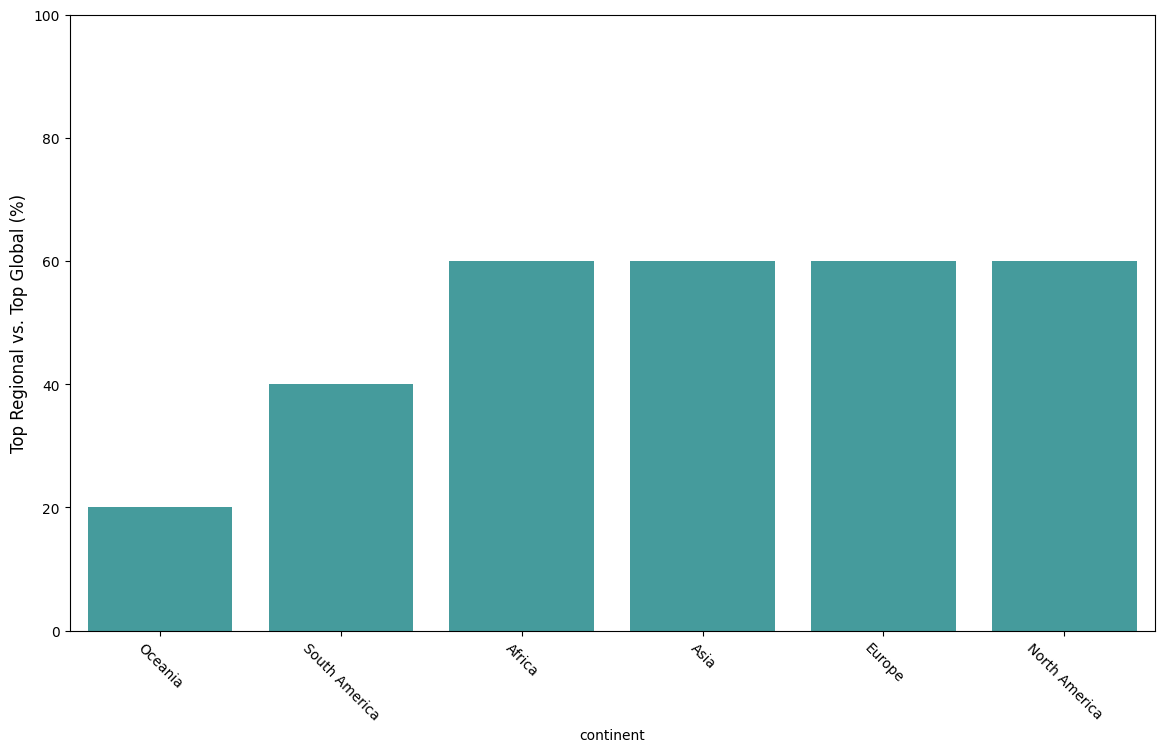

In [199]:
plt.figure(figsize=(14, 8))
sns.barplot(data=matching_tops, x='continent', y='matching_percent')

plt.ylim(0, 100)

plt.xticks(rotation=-45)

plt.ylabel("Top Regional vs. Top Global (%)", fontsize=12)


sns.barplot(data=matching_tops, x='continent', y='matching_percent', palette=["#36a9ab"])
plt.show()


### Hipotesis 4
**Influencia de la estacionalidad**  
   Habiendo realizado la extracción el 27/12, y sabiendo de la inmediatez de las redes sociales, encontraremos canciones temáticas de Navidad en puestos intermedios del ranking.

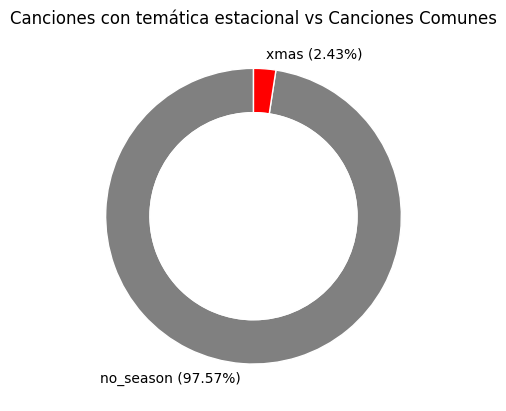

In [263]:
season_percent = top50_songs_world['season'].value_counts(normalize=True)
percentages = (season_percent * 100).round(2)  # Redondear a 2 decimales, esto nos ayudará para las leyendas
labels = [f"{label} ({percentage}%)" for label, percentage in zip(season_percent.index, percentages)]

color_map = {
    "xmas": "red",
    "no_season": "grey",
}
colors = [color_map[label.lower()] for label in season_percent.index] 
plt.pie(
    season_percent,
    labels=labels,  
    startangle=90,
    colors=colors, 
    wedgeprops=dict(width=0.3, edgecolor='w',)
)

my_circle = plt.Circle((0, 0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Canciones con temática estacional vs Canciones Comunes")
plt.show()

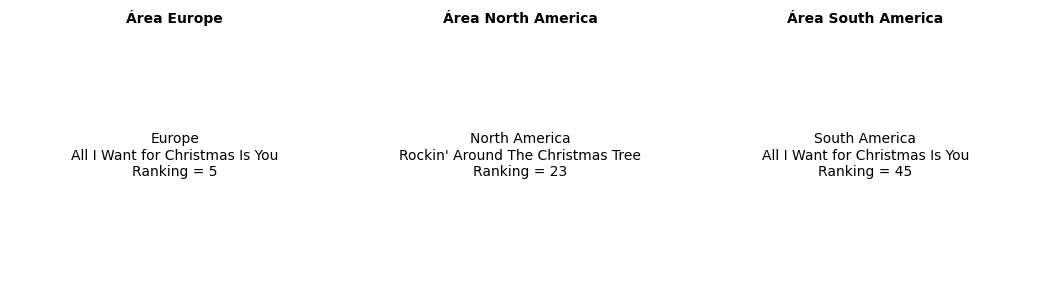

In [ ]:
# Supongamos que este es tu DataFrame después del groupby
grouped = top50_songs_world[top50_songs_world['season'] == 'xmas'].groupby(
    ['Geographic_Area', 'Cancion']
)['Ranking'].min()

# Resetear el índice para facilitar el acceso a los datos
grouped_reset = grouped.reset_index()

# Encontrar la canción mejor posicionada (ranking más bajo) por área geográfica
best_songs = grouped_reset.loc[grouped_reset.groupby('Geographic_Area')['Ranking'].idxmin()]

# Ordenar el DataFrame `best_songs` según el criterio personalizado
best_songs = best_songs.sort_values(by="Geographic_Area", key=lambda x: x.map(custom_sort))

# Definir dimensiones de la cuadrícula
n_cols = 3  # Número de columnas por fila
n_rows = math.ceil(len(best_songs) / n_cols)  # Calcular filas necesarias

# Crear el gráfico con subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10.5, 3.))
axes = axes.flatten()  # Aplanar la cuadrícula para iterar fácilmente

# Iterar por cada área geográfica y añadir texto en las celdas
for i, row in enumerate(best_songs.itertuples()):
    ax = axes[i]
    ax.axis('off')  # Ocultar ejes
    ax.text(
        0.5, 0.5,  # Coordenadas en el centro de la celda
        f"{row.Geographic_Area}\n{row.Cancion}\nRanking = {row.Ranking}",  # Texto
        fontsize=10, ha='center', va='center', color="black"
    )
    ax.set_title(f"Área {row.Geographic_Area}", fontsize=10, weight='bold')  # Título

# Ocultar subplots vacíos si el número de áreas no llena la cuadrícula
for ax in axes[len(best_songs):]:
    ax.axis('off')

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Hipotesis 5
**Influencia del formato**  
   Tanto por la tendencia actual, tanto por la naturaleza del Ranking, que está midiendo viralidad/tendencia. Nos encontraremos con el valor Single dominando  la categoría album_types.

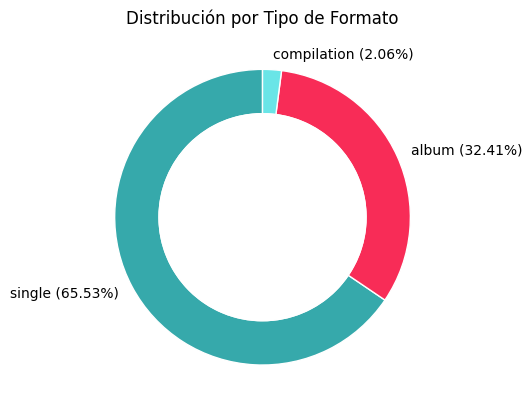

In [56]:
album_counts = top50_songs_world['Album_Type'].value_counts(normalize=True)
percentages = (album_counts * 100).round(2)  # Redondear a 2 decimales, esto nos ayudará para las leyendas
labels = [f"{label} ({percentage}%)" for label, percentage in zip(album_counts.index, percentages)]

color_map = {
    "single": "#36a9ab",
    "album": "#f82c57",
    "compilation": "#6ae5e7"
}
colors = [color_map[label.lower()] for label in album_counts.index] 
plt.pie(
    album_counts,
    labels=labels,  
    startangle=90,
    colors=colors, 
    wedgeprops=dict(width=0.3, edgecolor='w',)
)

my_circle = plt.Circle((0, 0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Distribución por Tipo de Formato")
plt.show()

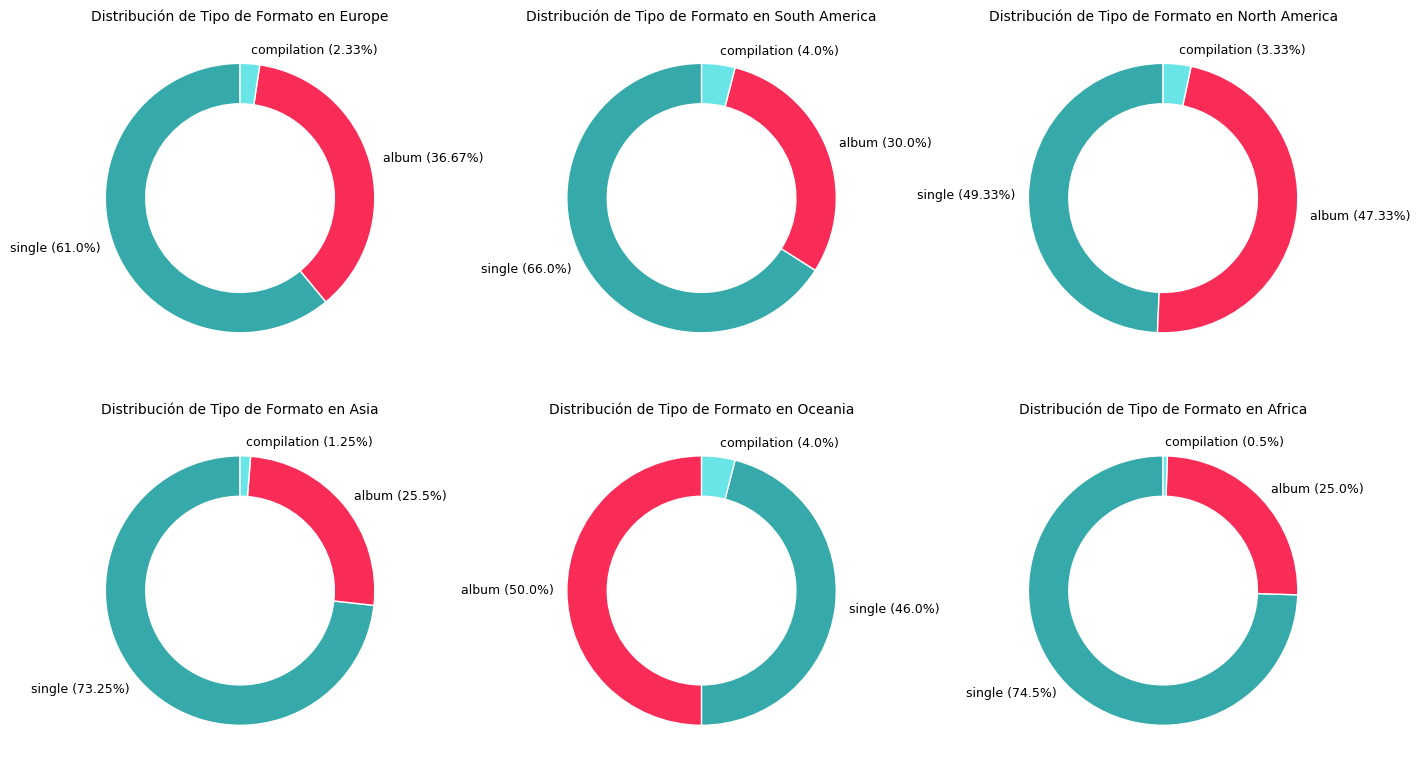

In [58]:
areas = sorted(top50_songs_world['Geographic_Area'].unique(), key=custom_sort)

# Definir el número de filas y columnas para la cuadrícula
n_cols = 3  # Número de gráficos por fila
n_rows = math.ceil(len(areas) / n_cols)  # Calcular el número de filas necesario

# Configurar el tamaño del canvas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))  # Tamaño ajustado
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

# Iterar por cada área y crear un gráfico
for i, area in enumerate(areas):
    ax = axes[i]
    
    # Filtrar datos por área
    area_data = top50_songs_world[top50_songs_world['Geographic_Area'] == area]
    
    # Calcular la distribución de tipos de álbum para el área
    album_counts = area_data['Album_Type'].value_counts(normalize=True)
    percentages = (album_counts * 100).round(2)  # Redondear a 2 decimales
    labels = [f"{label} ({percentage}%)" for label, percentage in zip(album_counts.index, percentages)]
    colors = [color_map[label] for label in album_counts.index if label in color_map]  # Validar existencia en color_map
    
    # Crear el gráfico de pastel en el eje correspondiente
    ax.pie(
        album_counts,
        labels=labels,
        startangle=90,
        colors=colors,  # Aplicar colores fijos
        wedgeprops=dict(width=0.3, edgecolor='w'),
        textprops=dict(size=9)  # Tamaño del texto en las etiquetas
    )
    
    # Configurar el título del subgráfico
    ax.set_title(f'Distribución de Tipo de Formato en {area}', fontsize=10)

# Desactivar gráficos vacíos si el número de áreas no llena la cuadrícula
for ax in axes[len(areas):]:
    ax.axis('off')

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

